In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = "data/"
AFDB_2019 = "Data.csv"
db_zero_all_dates = pd.read_csv(DATA_PATH + AFDB_2019, sep=',')

INDICATORS = "Indicator.csv"
inds = pd.read_csv(DATA_PATH + INDICATORS, sep=',')

print(db_zero_all_dates.shape)
db_zero_all_dates.dropna(subset=['Date', 'Value','Country','Indicator'],inplace = True) 
#Uses 'any' by default in "how" argument, which concludes our rows are good, when shape (nb of rows specifically) is same.
print(db_zero_all_dates.shape)


db_zero_all_dates.Date = db_zero_all_dates.Date.apply(lambda x : x.split("-")[0]).astype(int)
db_zero_all_dates.rename(columns = {'Date':'Year'}, inplace = True)
db_zero_all_dates.Scale = db_zero_all_dates.Scale.astype(int)
db_zero_all_dates.Value = db_zero_all_dates.Value.astype(float)
db_zero_all_dates.head()

(2792569, 9)
(2792569, 9)


,CountryName,Country,IndicatorName,Indicator,Units,Scale,Frequency,Year,Value
0,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2000,9.133374
1,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2001,8.535367
2,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2002,7.238168
3,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2003,7.217622
4,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2004,7.373657


In [3]:
#drop all rows with year > 2019
db_zero_all_dates.Year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050], dtype=int64)

In [4]:
db_zero = db_zero_all_dates[db_zero_all_dates.Year < 2020]
print(db_zero_all_dates.shape)
db_zero.shape

(2792569, 9)


(2772197, 9)

In [5]:
db = pd.pivot_table(db_zero, values='Value', index=['Country','Year'], columns=['Indicator'])
print(db.shape)
db.head()

(6502, 1279)


Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
ADB     1960                NaN                NaN                NaN   
        1961                NaN                NaN                NaN   
        1962                NaN                NaN                NaN   
        1963                NaN                NaN                NaN   
        1964                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
ADB     1960             NaN                 NaN                 NaN   
        1961             NaN                 NaN                 NaN   
        1962             NaN                 NaN                 NaN   
        1963             NaN                 NaN                 NaN   
        1964             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
ADB     1960          NaN                   NaN                    NaN   
        1961          NaN                   NaN                    NaN   
        1962          NaN                   NaN                    NaN   
        1963          NaN                   NaN                    NaN   
        1964          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
ADB     1960                   NaN  ...                NaN              NaN   
        1961                   NaN  ...                NaN              NaN   
        1962                   NaN  ...                NaN              NaN   
        1963                   NaN  ...                NaN              NaN   
        1964                   NaN  ...                NaN              NaN   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                                                                    
ADB     1960              NaN              NaN            NaN             NaN   
        1961              NaN              NaN            NaN             NaN   
        1962              NaN              NaN            NaN             NaN   
        1963              NaN              NaN            NaN             NaN   
        1964              NaN              NaN            NaN             NaN   

Indicator     TG.WEO.TX_R.KD  TG.WEO.TX_R.ZG  VC.PRS.UNSEC  indicateur3  
Country Year                                                             
ADB     1960             NaN             NaN           NaN          NaN  
        1961             NaN             NaN           NaN          NaN  
        1962             NaN             NaN           NaN          NaN  
        1963             NaN             NaN           NaN          NaN  
        1964             NaN             NaN           NaN          NaN  

[5 rows x 1279 columns]

In [6]:
db_verif = db.dropna(how='all')
db_verif.shape
#Still, no key(country,year) has all nans, each key has its indicators !

(6502, 1279)

In [7]:
def lowercase_all(text):
    return text.lower()

In [8]:
education_keywords = ['education','literacy','enrol','school','teach','pupil','stud','repeat',
                      'test','search','grade','intern','knowledge','lab','read','prof','write','report','skill']

'''
['university','department','degree','learn','college','academic','assessment','class','course','curriculum','exam',
'faculty','instruct','intellect','language','quizz', ..etc] 
These keywords and many others didn't add a single row to the result, Hence we discarded them.
We have chosen these keywords based on the data examined manually to look a bit what we are dealing with, and from well known
education related dictionaries.
'''

inds_education = inds[inds.Name.apply(lowercase_all).str.contains('|'.join(education_keywords))]
print(inds_education.shape)

(201, 11)


In [9]:
inds_education.head()

,Order,Name,Parent,Code,Indicator_Id,Source_Note,Derivation_Rule,IsDerived,Weights_Indicator,Aggregation_Rule,Unit
31,32,Internet users per 100 inhabitants,KN.B5,IT.NET.USER.P3,9.0,Internet users refers to the number of people ...,(('IT.NET.USER'/ 'SP.POP.TOTL' )*100),1.0,NaN,DERIVE(('IT.NET.USER'/ 'SP.POP.TOTL' )*100),per 100 inhabitants
32,33,Proportion of individuals using the Internet,KN.B5,IT.USE.ii99,1730.0,Proportion of individuals using the Internet i...,NaN,0.0,NaN,NaN,NaN
42,43,Internet users,KN.B5,IT.NET.USER,482.0,Internet users refers to the number of people ...,NaN,0.0,NaN,NaN,NaN
43,44,Internet Subscribers,KN.B5,IT.NET.SCRB,911.0,'Internet subscribers refers to the number of ...,NaN,0.0,NaN,NaN,NaN
46,47,Fixed Internet broadband Subscriptions per 100...,KN.B5,IT.NET.BBND,1706.0,"Fixed Internet broadband subscriptions, by spe...",NaN,0.0,NaN,NaN,per 100 inhabitants


In [10]:
education_codes = inds_education.Code.unique().tolist()
len(education_codes)

201

In [11]:
db_education = db_zero[db_zero.Indicator.str.match('|'.join(education_codes))]
print(db_education.shape)
db_education.head()

(226452, 9)


,CountryName,Country,IndicatorName,Indicator,Units,Scale,Frequency,Year,Value
399,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1991,0.000737
400,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1992,0.002143
401,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1993,0.006324
402,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1994,0.014261
403,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1995,0.040432


In [123]:
db_ed = pd.pivot_table(db_education, values='Value', index=['Country', 'Year'], columns=['Indicator'])

#thresh=N requires that a column has at least N non-NaNs to survive !!
#We chose to work with an indicator if at least half of its values are not missing.

th = 0.5
print(db_ed.shape)
db_ed.dropna(axis=1,thresh=int(th*db_ed.shape[0]),inplace=True)
print(db_ed.shape)
db_ed

(6351, 161)
(6351, 28)


Indicator     AG.POP.EAC.TOT.ZS  FI.RES.TOTL.CD  FI.RES.TOTL.MO  \
Country Year                                                      
ADB     1960                NaN             NaN             NaN   
        1961                NaN             NaN             NaN   
        1962                NaN             NaN             NaN   
        1963                NaN             NaN             NaN   
        1964                NaN             NaN             NaN   
...                         ...             ...             ...   
ZZM     2015          38.808109             NaN             NaN   
        2016          38.970121             NaN             NaN   
        2017          39.162227             NaN             NaN   
        2018          39.375855             NaN             NaN   
        2019          39.599083             NaN             NaN   

Indicator     NY.GDP.PCAP.PP.CD  SE.POP.PRM.NENR.FE  SE.POP.PRM.NENR.MA  \
Country Year                                                              
ADB     1960           0.000000                 NaN                 NaN   
        1961           0.000000                 NaN                 NaN   
        1962           0.000000                 NaN                 NaN   
        1963           0.000000                 NaN                 NaN   
        1964           0.000000                 NaN                 NaN   
...                         ...                 ...                 ...   
ZZM     2015        4939.250861                 NaN                 NaN   
        2016        4977.914574                 NaN                 NaN   
        2017        5100.468429                 NaN                 NaN   
        2018        5253.779942                 NaN                 NaN   
        2019        5423.624072                 NaN                 NaN   

Indicator     SE.POP.PRM.NENR.TOT  SE.POP.SEC.NENR.FE  SE.POP.SEC.NENR.MA  \
Country Year                                                                
ADB     1960                  NaN                 NaN                 NaN   
        1961                  NaN                 NaN                 NaN   
        1962                  NaN                 NaN                 NaN   
        1963                  NaN                 NaN                 NaN   
        1964                  NaN                 NaN                 NaN   
...                           ...                 ...                 ...   
ZZM     2015                  NaN                 NaN                 NaN   
        2016                  NaN                 NaN                 NaN   
        2017                  NaN                 NaN                 NaN   
        2018                  NaN                 NaN                 NaN   
        2019                  NaN                 NaN                 NaN   

Indicator     SE.POP.SEC.NENR.TOT  ...  SE.PRM.ENRR.MA  SE.PRM.ENRR.NUM.FE  \
Country Year                       ...                                       
ADB     1960                  NaN  ...             NaN                 NaN   
        1961                  NaN  ...             NaN                 NaN   
        1962                  NaN  ...             NaN                 NaN   
        1963                  NaN  ...             NaN                 NaN   
        1964                  NaN  ...             NaN                 NaN   
...                           ...  ...             ...                 ...   
ZZM     2015                  NaN  ...             NaN                 NaN   
        2016                  NaN  ...             NaN                 NaN   
        2017                  NaN  ...             NaN                 NaN   
        2018                  NaN  ...             NaN                 NaN   
        2019                  NaN  ...             NaN                 NaN   

Indicator     SE.PRM.ENRR.NUM.MA  SE.PRM.ENRR.NUM.TO  SE.SEC.ENRR.NUM.FE  \
Country Year                                               

In [13]:
#baad el pivot, el nombre de colonnes au lieu de 201 tla3 161, all nans yetfaskhou??
db_ed.columns

Index(['AG.POP.EAC.TOT.ZS', 'FI.RES.TOTL.CD', 'FI.RES.TOTL.MO',
       'NY.GDP.PCAP.PP.CD', 'SE.POP.PRM.NENR.FE', 'SE.POP.PRM.NENR.MA',
       'SE.POP.PRM.NENR.TOT', 'SE.POP.SEC.NENR.FE', 'SE.POP.SEC.NENR.MA',
       'SE.POP.SEC.NENR.TOT', 'SE.POP.TERT.NENR.FE', 'SE.POP.TERT.NENR.MA',
       'SE.POP.TERT.NENR.TOT', 'SE.PRIM.TCHR.FE', 'SE.PRIM.TCHR.TO',
       'SE.PRM.ENRL.TC.ZS', 'SE.PRM.ENRR', 'SE.PRM.ENRR.FE', 'SE.PRM.ENRR.MA',
       'SE.PRM.ENRR.NUM.FE', 'SE.PRM.ENRR.NUM.MA', 'SE.PRM.ENRR.NUM.TO',
       'SE.SEC.ENRR.NUM.FE', 'SE.SEC.ENRR.NUM.MA', 'SE.SEC.ENRR.NUM.TO',
       'SE.YRS.SCHL.FE', 'SE.YRS.SCHL.MA', 'SE.YRS.SCHL.TO'],
      dtype='object', name='Indicator')

In [14]:
'''
Now it's time to check manually the description of the 28 selected attributes (indicators) to see if they are really
education-related, hence relevant for our study, or not.
Because until now the only filter we have done is selecting indicators with description containing one of those 
education-related keywords from above.
'''

'''
cc = 0
for i in range(inds_education.shape[0]):
    if (inds_education.Code.str.contains(('|'.join(db_ed.columns)))[i]):
        cc +=1
print(cc)    
'''
#Working with inds_education we only match 22 (but contains 28), ERROR? !!
inds_educ_after_nan_codes = inds[inds.Code.str.match('|'.join(db_ed.columns))]

inds_educ_after_nan_codes = inds_educ_after_nan_codes[['Code','Name','Source_Note']]
print(inds_educ_after_nan_codes.shape)
inds_educ_after_nan_codes

(28, 3)


,Code,Name,Source_Note
236,AG.POP.EAC.TOT.ZS,Labour force participation (as % of total),NaN
418,NY.GDP.PCAP.PP.CD,"GDP Per capita, PPP (current international $)",'GDP per capita based on purchasing power pari...
1242,FI.RES.TOTL.MO,Gross international reserves in months of imports,Gross international reserves expressed in mont...
1243,FI.RES.TOTL.CD,Gross international reserves (current US$),Gross international reserves comprise holdings...
1289,SE.PRM.ENRL.TC.ZS,"Pupil-teacher ratio, primary",Primary school pupil-teacher ratio is the numb...
1290,SE.PRM.ENRR,"School enrollment, primary (% gross)",Gross enrollment ratio is the ratio of total e...
1291,SE.PRM.ENRR.FE,"School enrollment, primary, female (% gross)",Gross enrollment ratio is the ratio of female ...
1292,SE.PRM.ENRR.MA,"School enrollment, primary, male (% gross)",Gross enrollment ratio is the ratio of male en...
1312,SE.YRS.SCHL.FE,"School Life Expectancy, female (year)",School life expectancy is defined as the total...
1469,SE.YRS.SCHL.MA,School Life Expectancy - Male (years),Male school life expectancy is defined as the ...


In [15]:
'''
We see that the first 4 shown indicators, which are:

AG.POP.EAC.TOT.ZS   -    Labour force participation (as % of total)
NY.GDP.PCAP.PP.CD   -    GDP Per capita, PPP (current international $)
FI.RES.TOTL.MO      -    Gross international reserves in months of imports
FI.RES.TOTL.CD      -    Gross international reserves (current US$)

have nothing to do with what we are looking for, they were only present because of the keywords : "lab" for the first
indicator when looking for potential description including a laboratory, and "intern" for the 3 others when looking 
for potential description including an intern student or an internship ..

Hence we can exclude these 4 indicators.
'''
print(db_ed.shape)
db_ed = db_ed.drop(columns=['AG.POP.EAC.TOT.ZS','NY.GDP.PCAP.PP.CD','FI.RES.TOTL.MO','FI.RES.TOTL.CD'])
db_ed.shape

(6351, 28)


(6351, 24)

In [16]:
'''
inds_social = inds[inds['Parent']=='KN.B14']
print(inds.shape)
print(inds_social.shape)
'''
db_ed

Indicator     SE.POP.PRM.NENR.FE  SE.POP.PRM.NENR.MA  SE.POP.PRM.NENR.TOT  \
Country Year                                                                
ADB     1960                 NaN                 NaN                  NaN   
        1961                 NaN                 NaN                  NaN   
        1962                 NaN                 NaN                  NaN   
        1963                 NaN                 NaN                  NaN   
        1964                 NaN                 NaN                  NaN   
...                          ...                 ...                  ...   
ZZM     2015                 NaN                 NaN                  NaN   
        2016                 NaN                 NaN                  NaN   
        2017                 NaN                 NaN                  NaN   
        2018                 NaN                 NaN                  NaN   
        2019                 NaN                 NaN                  NaN   

Indicator     SE.POP.SEC.NENR.FE  SE.POP.SEC.NENR.MA  SE.POP.SEC.NENR.TOT  \
Country Year                                                                
ADB     1960                 NaN                 NaN                  NaN   
        1961                 NaN                 NaN                  NaN   
        1962                 NaN                 NaN                  NaN   
        1963                 NaN                 NaN                  NaN   
        1964                 NaN                 NaN                  NaN   
...                          ...                 ...                  ...   
ZZM     2015                 NaN                 NaN                  NaN   
        2016                 NaN                 NaN                  NaN   
        2017                 NaN                 NaN                  NaN   
        2018                 NaN                 NaN                  NaN   
        2019                 NaN                 NaN                  NaN   

Indicator     SE.POP.TERT.NENR.FE  SE.POP.TERT.NENR.MA  SE.POP.TERT.NENR.TOT  \
Country Year                                                                   
ADB     1960                  NaN                  NaN                   NaN   
        1961                  NaN                  NaN                   NaN   
        1962                  NaN                  NaN                   NaN   
        1963                  NaN                  NaN                   NaN   
        1964                  NaN                  NaN                   NaN   
...                           ...                  ...                   ...   
ZZM     2015                  NaN                  NaN                   NaN   
        2016                  NaN                  NaN                   NaN   
        2017                  NaN                  NaN                   NaN   
        2018                  NaN                  NaN                   NaN   
        2019                  NaN                  NaN                   NaN   

Indicator     SE.PRIM.TCHR.FE  ...  SE.PRM.ENRR.MA  SE.PRM.ENRR.NUM.FE  \
Country Year                   ...                                       
ADB     1960              NaN  ...             NaN                 NaN   
        1961              NaN  ...             NaN                 NaN   
        1962              NaN  ...             NaN                 NaN   
        1963              NaN  ...             NaN                 NaN   
        1964              NaN  ...             NaN                 NaN   
...                       ...  ...             ...                 ...   
ZZM     2015              NaN  ...             NaN                 NaN   
        2016              NaN  ...             NaN                 NaN   
        2017              NaN  ...             NaN                 NaN   
        2018              NaN  ...             NaN                 NaN   
        2019              NaN  ...             NaN                 

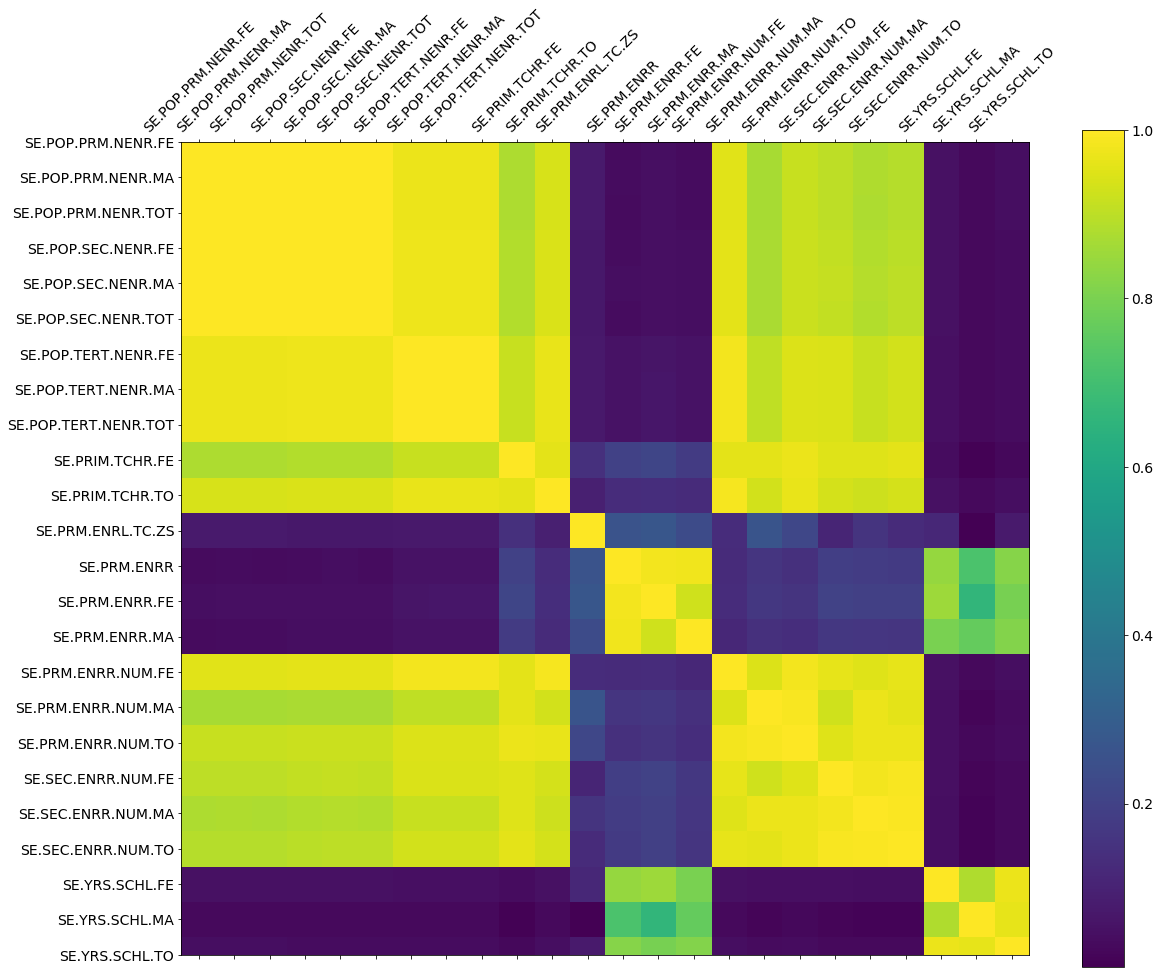

In [17]:
f = plt.figure(figsize=(19, 15))
plt.matshow(db_ed.corr(), fignum=f.number)
plt.xticks(range(db_ed.shape[1]), db_ed.columns, fontsize=14, rotation=45)
plt.yticks(range(db_ed.shape[1]), db_ed.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [18]:
corr = db_ed.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

Indicator,SE.POP.PRM.NENR.FE,SE.POP.PRM.NENR.MA,SE.POP.PRM.NENR.TOT,SE.POP.SEC.NENR.FE,SE.POP.SEC.NENR.MA,SE.POP.SEC.NENR.TOT,SE.POP.TERT.NENR.FE,SE.POP.TERT.NENR.MA,SE.POP.TERT.NENR.TOT,SE.PRIM.TCHR.FE,SE.PRIM.TCHR.TO,SE.PRM.ENRL.TC.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.PRM.ENRR.NUM.FE,SE.PRM.ENRR.NUM.MA,SE.PRM.ENRR.NUM.TO,SE.SEC.ENRR.NUM.FE,SE.SEC.ENRR.NUM.MA,SE.SEC.ENRR.NUM.TO,SE.YRS.SCHL.FE,SE.YRS.SCHL.MA,SE.YRS.SCHL.TO
Indicator,,,,,,,,,,,,,,,,,,,,,,,,
SE.POP.PRM.NENR.FE,1,1,1,0.999,0.999,0.999,0.972,0.972,0.972,0.877,0.94,0.0768,0.0361,0.0445,0.0364,0.955,0.871,0.916,0.901,0.879,0.89,0.0506,0.0321,0.0416
SE.POP.PRM.NENR.MA,1,1,1,1,1,1,0.972,0.972,0.972,0.879,0.94,0.0764,0.038,0.0464,0.0382,0.955,0.872,0.917,0.902,0.88,0.891,0.0506,0.0319,0.0415
SE.POP.PRM.NENR.TOT,1,1,1,1,0.999,1,0.972,0.972,0.972,0.878,0.94,0.0766,0.0371,0.0454,0.0373,0.955,0.871,0.916,0.902,0.88,0.891,0.0506,0.032,0.0416
SE.POP.SEC.NENR.FE,0.999,1,1,1,1,1,0.975,0.975,0.975,0.885,0.943,0.07,0.0399,0.0466,0.0422,0.959,0.875,0.92,0.91,0.887,0.899,0.0496,0.031,0.0406
SE.POP.SEC.NENR.MA,0.999,1,0.999,1,1,1,0.975,0.975,0.975,0.885,0.943,0.0689,0.0417,0.0485,0.044,0.959,0.876,0.92,0.911,0.887,0.899,0.0496,0.0308,0.0405
SE.POP.SEC.NENR.TOT,0.999,1,1,1,1,1,0.975,0.975,0.975,0.885,0.943,0.0694,0.0408,0.0475,0.0431,0.959,0.875,0.92,0.911,0.887,0.899,0.0496,0.0309,0.0405
SE.POP.TERT.NENR.FE,0.972,0.972,0.972,0.975,0.975,0.975,1,1,1,0.917,0.967,0.074,0.0544,0.0639,0.0537,0.984,0.904,0.949,0.943,0.918,0.932,0.0484,0.03,0.0395
SE.POP.TERT.NENR.MA,0.972,0.972,0.972,0.975,0.975,0.975,1,1,1,0.918,0.967,0.0726,0.0562,0.0656,0.0557,0.984,0.905,0.949,0.944,0.918,0.933,0.0484,0.0298,0.0393
SE.POP.TERT.NENR.TOT,0.972,0.972,0.972,0.975,0.975,0.975,1,1,1,0.917,0.967,0.0733,0.0553,0.0648,0.0547,0.984,0.905,0.949,0.943,0.918,0.933,0.0484,0.0299,0.0394


In [19]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['SE.POP.PRM.NENR.MA',
 'SE.POP.PRM.NENR.TOT',
 'SE.POP.SEC.NENR.FE',
 'SE.POP.SEC.NENR.MA',
 'SE.POP.SEC.NENR.TOT',
 'SE.POP.TERT.NENR.FE',
 'SE.POP.TERT.NENR.MA',
 'SE.POP.TERT.NENR.TOT',
 'SE.PRIM.TCHR.TO',
 'SE.PRM.ENRR.FE',
 'SE.PRM.ENRR.MA',
 'SE.PRM.ENRR.NUM.FE',
 'SE.PRM.ENRR.NUM.MA',
 'SE.PRM.ENRR.NUM.TO',
 'SE.SEC.ENRR.NUM.FE',
 'SE.SEC.ENRR.NUM.MA',
 'SE.SEC.ENRR.NUM.TO',
 'SE.YRS.SCHL.TO']

In [20]:
to_keep = [element for element in upper.columns if element not in to_drop]
db_keep = db_ed[to_keep]
print(db_keep.shape)
to_keep

(6351, 6)


['SE.POP.PRM.NENR.FE',
 'SE.PRIM.TCHR.FE',
 'SE.PRM.ENRL.TC.ZS',
 'SE.PRM.ENRR',
 'SE.YRS.SCHL.FE',
 'SE.YRS.SCHL.MA']

In [21]:
'''
What we're doing here is just replacing the School age population Primary-Female (SE.POP.PRM.NENR.FE) with the School 
age population Primary-Total and The Primary school teachers-Female (SE.PRIM.TCHR.FE) with the Enrolment in total 
primary-Total. (These are very correlated, we just did the replacement for name convenience, won't affect our findings)
'''

to_keep = pd.Series(to_keep).replace(['SE.POP.PRM.NENR.FE', 'SE.PRIM.TCHR.FE'],
                                     ['SE.POP.PRM.NENR.TOT', 'SE.PRM.ENRR.NUM.TO']).tolist()
to_keep

['SE.POP.PRM.NENR.TOT',
 'SE.PRM.ENRR.NUM.TO',
 'SE.PRM.ENRL.TC.ZS',
 'SE.PRM.ENRR',
 'SE.YRS.SCHL.FE',
 'SE.YRS.SCHL.MA']

In [22]:
db_final_ed = db_ed[to_keep]
corr_keep = db_final_ed.corr()
corr_keep.style.background_gradient(cmap='coolwarm').set_precision(3)

Indicator,SE.POP.PRM.NENR.TOT,SE.PRM.ENRR.NUM.TO,SE.PRM.ENRL.TC.ZS,SE.PRM.ENRR,SE.YRS.SCHL.FE,SE.YRS.SCHL.MA
Indicator,,,,,,
SE.POP.PRM.NENR.TOT,1,0.916,0.0766,0.0371,0.0506,0.032
SE.PRM.ENRR.NUM.TO,0.916,1,0.216,0.142,0.0483,0.0258
SE.PRM.ENRL.TC.ZS,0.0766,0.216,1,0.26,0.116,0.00612
SE.PRM.ENRR,0.0371,0.142,0.26,1,0.842,0.72
SE.YRS.SCHL.FE,0.0506,0.0483,0.116,0.842,1,0.883
SE.YRS.SCHL.MA,0.032,0.0258,0.00612,0.72,0.883,1


In [23]:
'''
We conclude our final Education related attributes that we're gonna work with:

SE.POP.PRM.NENR.TOT - School age population Primary Total 
-->From correlation observations, this also represents the School age population for Secondary and Tertiaty.

SE.PRM.ENRR.NUM.TO  - Enrollment in total primary, Total
-->From correlation observations, this also represents the Enrollment in total for Secondary School as well as the number
of (primary) school teachers.

SE.PRM.ENRL.TC.ZS   - Pupil-teacher ratio, primary
SE.PRM.ENRR         - School enrollment, primary (% gross)
SE.YRS.SCHL.FE      - School Life Expectancy - Female (years)
SE.YRS.SCHL.MA      - School Life Expectancy - Male (years)

We let the School life expectancy for Females and Males separated because we found out they are not very correlated
and hence can lead us to good/unexpected results.

'''
#How are School enrollment, primary (% gross) and Enrollment in total primary Total,not highly correlated ?!

#Create new attribute from 2: enrollment % of school aged population =  SE.PRM.ENRR.NUM.TO / SE.POP.PRM.NENR.TOT

#Plot all our final variables against each other for some specific country (region), across the "possible"
#(where our data is complete) years.

#Extract the social and economical growth variables, to see how they are related with education.

#Answer some of the research questions

#index?

#plot colored maps of different regions/countries in Africa, selon les resultats trouvés.

"\nWe conclude our final Education related attributes that we're gonna work with:\n\nSE.POP.PRM.NENR.TOT - School age population Primary Total \n-->From correlation observations, this also represents the School age population for Secondary and Tertiaty.\n\nSE.PRM.ENRR.NUM.TO  - Enrollment in total primary, Total\n-->From correlation observations, this also represents the Enrollment in total for Secondary School as well as the number\nof (primary) school teachers.\n\nSE.PRM.ENRL.TC.ZS   - Pupil-teacher ratio, primary\nSE.PRM.ENRR         - School enrollment, primary (% gross)\nSE.YRS.SCHL.FE      - School Life Expectancy - Female (years)\nSE.YRS.SCHL.MA      - School Life Expectancy - Male (years)\n\nWe let the School life expectancy for Females and Males separated because we found out they are not very correlated\nand hence can lead us to good/unexpected results.\n\n"

Text(0.5, 1.0, 'School Life Expectancy (Male)')

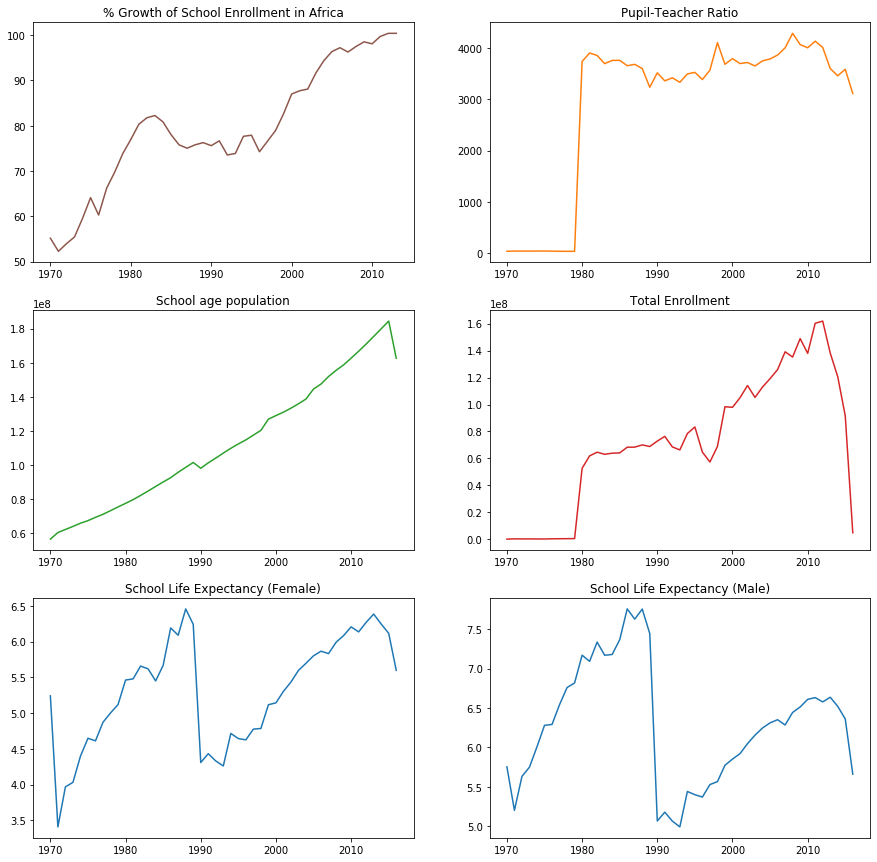

In [26]:
#Plots of chosen variables:

db_afr_indexes = db_zero[['Country','Year','Indicator','Value']]
db_afr_indexes = db_afr_indexes[db_afr_indexes.Country == 'AFR']


fig, axs = plt.subplots(3, 2,figsize=(15,15))

db_afr_ind_1 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.PRM.ENRR']
axs[0, 0].plot(db_afr_ind_1.Year,db_afr_ind_1.Value, 'tab:brown')
axs[0, 0].set_title('% Growth of School Enrollment in Africa')

db_afr_ind_2 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.PRM.ENRL.TC.ZS']
axs[0, 1].plot(db_afr_ind_2.Year,db_afr_ind_2.Value, 'tab:orange')
axs[0, 1].set_title('Pupil-Teacher Ratio')

db_afr_ind_3 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.POP.PRM.NENR.TOT']
axs[1, 0].plot(db_afr_ind_3.Year,db_afr_ind_3.Value, 'tab:green')
axs[1, 0].set_title('School age population')

db_afr_ind_4 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.PRM.ENRR.NUM.TO']
axs[1, 1].plot(db_afr_ind_4.Year,db_afr_ind_4.Value, 'tab:red')
axs[1, 1].set_title('Total Enrollment')

db_afr_ind_5 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.YRS.SCHL.FE']
axs[2, 0].plot(db_afr_ind_5.Year,db_afr_ind_5.Value)
axs[2, 0].set_title('School Life Expectancy (Female)')

db_afr_ind_6 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.YRS.SCHL.MA']
axs[2, 1].plot(db_afr_ind_6.Year,db_afr_ind_6.Value)
axs[2, 1].set_title('School Life Expectancy (Male)')

Text(0, 0.5, 'Number of years')

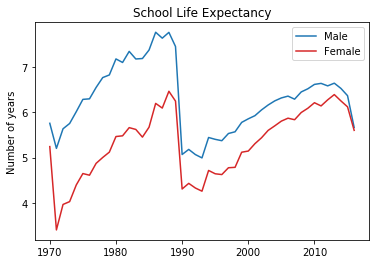

In [27]:
#For a better look in diff between the 2 genders!!
plt.plot(db_afr_ind_6.Year,db_afr_ind_6.Value,db_afr_ind_5.Year,db_afr_ind_5.Value,'tab:red')
plt.title('School Life Expectancy')
plt.legend(['Male','Female'])
plt.ylabel('Number of years')

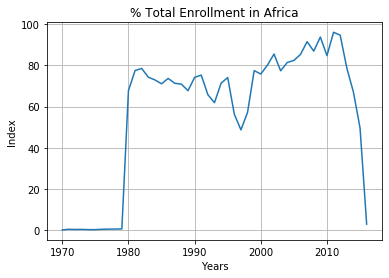

In [28]:
db_afr_ind_new = db_afr_indexes.copy()

nom_1 = db_afr_ind_new[db_afr_ind_new.Indicator == 'SE.PRM.ENRR.NUM.TO']

denom_1 = db_afr_ind_new[db_afr_ind_new.Indicator == 'SE.POP.PRM.NENR.TOT']

nom = nom_1['Value']
nom_f = nom.reset_index(drop=True)

denom = denom_1['Value']
denom_f = denom.reset_index(drop=True)

res = (nom_f/denom_f)*100
#print(res) 

dates = range(1970,2017)

plt.plot(dates,res)
plt.xlabel('Years')
plt.ylabel('Index')
plt.title('% Total Enrollment in Africa')
plt.grid()
plt.show()

In [78]:
'''
import os
import folium
import json

location_afr = [9,18]

geo_data = os.path.join('./maps/', 'africa.json')
m_afr = folium.Map(location_afr, tiles='cartodbpositron', zoom_start=3)
folium.GeoJson(geo_data).add_to(m_afr)
m_afr


"\nimport os\nimport folium\nimport json\n\nlocation_afr = [9,18]\n\ngeo_data = os.path.join('./maps/', 'africa.json')\nm_afr = folium.Map(location_afr, tiles='cartodbpositron', zoom_start=3)\nfolium.GeoJson(geo_data).add_to(m_afr)\nm_afr\n"

In [79]:
# Our countries?
db_zero.CountryName.unique()

array(['AFRICA', 'Central Africa', 'Cameroon', 'Central African Republic',
       'Chad', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Equatorial Guinea',
       'Gabon', 'Sao Tome and Principe', 'East Africa', 'Burundi',
       'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'World', 'AMU',
       'Kenya', 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Sudan',
       'Tanzania', 'Uganda', 'North Africa', 'Algeria', 'Egypt', 'Libya',
       'Mauritania', 'Morocco', 'Tunisia', 'Southern Africa', 'Angola',
       'Botswana', 'Lesotho', 'Madagascar', 'Malawi', 'Mauritius',
       'Mozambique', 'Namibia', 'South Africa', 'Swaziland', 'Zambia',
       'Zimbabwe', 'West Africa', 'Benin', 'Burkina Faso', 'Cape Verde',
       "Cote d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Mali', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone',
       'Togo', 'CAEMC', 'COMESA', 'ECCAS', 'ECOWAS', 'FRZONE', 'SADC',
       'WAEMU', 'Land Locked Countries', 'Mult. Dept Relief Initiative',

In [122]:
#From the list above, we see that multiple values are not needed (not only countries but also regions and set of countries
#that verify certain conditions)
#We will then eliminate this noisy data for these observations

import os
import folium
import json

location_afr = [9,18]
geo_data = os.path.join('./maps/', 'africa.json')


chosen_year = 2010

Countries_Only = ['Cameroon', 'Central African Republic','Chad', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Equatorial Guinea',
                 'Gabon', 'Sao Tome and Principe', 'Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia','Kenya',
                 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Sudan', 'Tanzania', 'Uganda', 'Algeria', 'Egypt',
                 'Libya', 'Mauritania', 'Morocco', 'Tunisia', 'Angola', 'Botswana', 'Lesotho', 'Madagascar', 'Malawi',
                 'Mauritius', 'Mozambique', 'Namibia', 'South Africa', 'Swaziland', 'Zambia', 'Zimbabwe', 'Benin',
                 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia',
                 'Mali', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone','Togo']

map_data = db_zero[['Country','CountryName','Year','Indicator','Value']].copy()

map_data = map_data[map_data.CountryName.isin(Countries_Only)]

map_data = map_data[map_data.Year == chosen_year]


#map_data = map_data.reset_index(drop=True)



#1

map_data_1 = map_data[map_data.Indicator == 'SE.PRM.ENRR']
#print(map_data_1)


thresh = 105

def africa_colors(country):
    """Maps drachneya to drachneya etc.."""
    grrr = map_data_1.loc[map_data_1['Country'] == country, 'Value'].values[0] > thresh
    if grrr :
        return '#0000ff'
    else:
        return '#ff0000'

m_afr = folium.Map(location_afr, tiles='cartodbpositron', zoom_start=3)
folium.GeoJson(
    geo_data,
    style_function=lambda feature: {
        'fillColor': africa_colors(feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(m_afr)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)